In [1]:
import itertools
import json
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from CDPL import Chem
from fame3r.compute_descriptors import DescriptorGenerator, MoleculeProcessor
from rdkit.Chem import AllChem, PandasTools

In [2]:
PandasTools.RenderImagesInAllDataFrames(images=True)

## Rule and test datasets from GLORYx

In [3]:
testset = pd.DataFrame(
    json.loads(
        Path("./GLORYx/datasets/test_dataset/gloryx_test_dataset.json").read_text()
    )
).pipe(lambda df: df.assign(Molecule=df.smiles.map(AllChem.MolFromSmiles)))

In [4]:
rules = (
    pd.read_csv("./GLORYx/reaction_rules/gloryx_reactionrules.csv")
    .pipe(
        lambda df: df.assign(
            Reaction=df.SMIRKS.map(lambda smirks: AllChem.ReactionFromSmarts(smirks))
        )
    )
    .set_index(["Reaction name"])
)

rules.apply(lambda row: row.Reaction.SetProp("_Name", row.name), axis=1)

pass

In [5]:
rules["Name of rule subset"].value_counts()

Name of rule subset
Phase 1 SyGMa rules               151
CYP rules from GLORY (phase 1)     73
UGT rules (phase 2)                13
GST rules (phase 2)                 9
NAT rules (phase 2)                 5
Other phase 2 rules                 4
SULT rules (phase 2)                3
MT rules (phase 2)                  2
Name: count, dtype: int64

In [6]:
rxn = rules.loc["N-demethylation_(R-NHCH3)", "Reaction"]

## Example molecule conversion

In [7]:
mol = AllChem.Mol(testset.loc[2, "Molecule"])

for atom in mol.GetAtoms():
    atom.SetIntProp("_Original", atom.GetIdx())

In [8]:
results = rules.Reaction.map(lambda rxn: rxn.RunReactants([mol])).pipe(
    lambda series: series[series != ()].map(np.concatenate)
)

results = np.concatenate(results.to_numpy())

In [9]:
prod = results[3]

In [10]:
retainedIdxs = [
    atom.GetIntProp("_Original")
    for atom in prod.GetAtoms()
    if atom.HasProp("_Original")
]

potentialSomIdxs = [
    atom.GetIdx() for atom in mol.GetAtoms() if atom.GetIdx() not in retainedIdxs
]

mol.__sssAtoms = potentialSomIdxs

for i, idx in enumerate(potentialSomIdxs):
    mol.GetAtomWithIdx(idx).SetAtomMapNum(i + 1)

mol_ = Chem.parseSMILES(AllChem.MolToSmiles(mol))
MoleculeProcessor.perceive_mol(mol_)

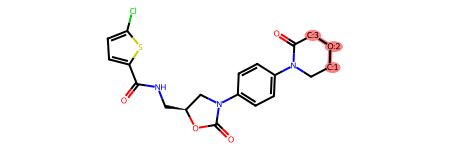

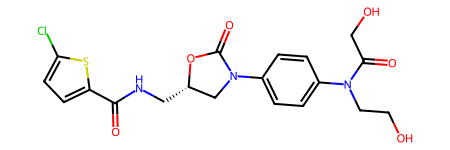

In [11]:
display(mol, prod)

## Example SOM probability prediction

In [12]:
famedg = DescriptorGenerator(radius=5)

In [13]:
fame3cf = joblib.load("./fame3r_data/model.joblib")

In [14]:
potential_soms = {
    atom.getProperty(Chem.AtomProperty.ATOM_MAPPING_ID): atom
    for atom in mol_.getAtoms()
    if atom.getProperty(Chem.AtomProperty.ATOM_MAPPING_ID)
}

In [15]:
fame3ds = [
    famedg.generate_descriptors(atom, mol_)[1] for atom in potential_soms.values()
]

In [16]:
fame3cf.predict_proba(fame3ds)[:, 1]

array([0.75, 0.06, 0.75])

## Potential library design #2

In [78]:
from pathlib import Path

import joblib
import numpy.typing as npt
from rdkit.Chem.rdmolops import GetDistanceMatrix

In [18]:
models = {
    path.name.removesuffix(".joblib"): joblib.load(path)
    for path in Path("models").glob("*.joblib")
}

In [170]:
subset_mappings = rules[~rules.index.duplicated()]["Name of rule subset"]

In [283]:
def get_strict_som_indices(reacted_mol: AllChem.Mol) -> npt.NDArray[np.int64]:
    heavy_atoms = [atom for atom in reacted_mol.GetAtoms() if atom.GetAtomicNum() != 1]
    new_idx = [
        atom.GetIdx() for atom in heavy_atoms if not atom.HasProp("react_atom_idx")
    ]
    retained_idx = np.array(
        [atom.GetIdx() for atom in heavy_atoms if atom.HasProp("react_atom_idx")]
    )

    # for atom in reacted_mol.GetAtoms():
    #    if atom.GetAtomicNum() == 1:
    #        continue
    #    atom.SetAtomMapNum(atom.GetIdx())

    # display(reacted_mol)
    # print(new_idx, list(retained_idx))
    # print()
    # display(
    #     pd.DataFrame(
    #         GetDistanceMatrix(
    #             AllChem.MolFromSmiles(AllChem.MolToSmiles(reacted_mol)),
    #         )[new_idx, :]
    #     )
    # )

    distances = GetDistanceMatrix(reacted_mol)[:, new_idx].min(axis=1)[retained_idx]
    mins = retained_idx[np.argwhere(distances == distances.min()).flatten()].astype(int)

    print(list(mins))

    return mins

In [248]:
def to_concrete_reactions(
    reaction: AllChem.ChemicalReaction, educt: AllChem.Mol
) -> AllChem.ChemicalReaction:
    products = itertools.chain.from_iterable(reaction.RunReactants([educt]))
    # TODO: fix what happens when reaction matches multiple times!
    products = {AllChem.MolToInchi(mol): mol for mol in products}.values()

    reactions = []
    for product in products:
        AllChem.SanitizeMol(product)
        product = AllChem.AddHs(product)
        educt_ = AllChem.Mol(educt)

        for product_idx in get_strict_som_indices(product):
            # educt_.GetAtomWithIdx(int(educt_idx)).SetAtomMapNum(react_atom_idx)
            product.GetAtomWithIdx(int(product_idx)).SetAtomMapNum(1)

        # for atom in product.GetAtoms():
        #    if atom.GetAtomicNum() == 1:
        #        continue
        #    product.GetAtomWithIdx(atom.GetIdx()).SetAtomMapNum(atom.GetIdx())

        # for atom in product.GetAtoms():
        #     if not atom.HasProp("old_mapno") or atom.GetAtomicNum() == 1:
        #         continue
        #
        #     mapno = atom.GetIntProp("old_mapno")
        #     educt_.GetAtomWithIdx(atom.GetIntProp("react_atom_idx")).SetAtomMapNum(
        #         mapno
        #     )
        #     product.GetAtomWithIdx(atom.GetIdx()).SetAtomMapNum(mapno)

        concrete_reaction = AllChem.ChemicalReaction()
        concrete_reaction.AddReactantTemplate(educt_)
        concrete_reaction.AddProductTemplate(product)
        if reaction.HasProp("_Name"):
            concrete_reaction.SetProp("_Name", reaction.GetProp("_Name"))

        reactions.append(concrete_reaction)

    return reactions

In [161]:
def educt_som_descriptors(marked_smiles: str) -> npt.NDArray[np.float64]:
    cdpkit_marked_educt = Chem.parseSMILES(marked_smiles)
    MoleculeProcessor.perceive_mol(cdpkit_marked_educt)

    som_atoms_unordered = {
        atom.getProperty(Chem.AtomProperty.ATOM_MAPPING_ID): atom
        for atom in cdpkit_marked_educt.getAtoms()
        if atom.getProperty(Chem.AtomProperty.ATOM_MAPPING_ID)
    }

    descriptors = [
        famedg.generate_descriptors(som_atoms_unordered[i], cdpkit_marked_educt)[1]
        for i in sorted(som_atoms_unordered.keys())
        if i in som_atoms_unordered  # TODO: make this create an all-nan entry instead
    ]

    return np.asarray(descriptors, dtype=np.float64)

In [162]:
def reactions_to_table(reactions: list[AllChem.ChemicalReaction]) -> pd.DataFrame:
    return pd.DataFrame(
        [
            {
                "Educt": rxn.GetReactants()[0],
                "Product": rxn.GetProducts()[0],
                "Reaction": rxn.GetProp("_Name") if rxn.HasProp("_Name") else None,
            }
            for rxn in reactions
        ]
    )

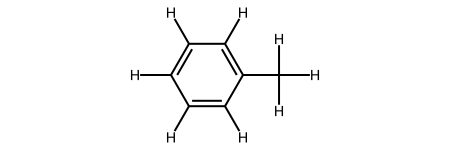

In [82]:
mol = AllChem.MolFromSmiles("c1ccccc1C")
mol = AllChem.AddHs(mol)
mol

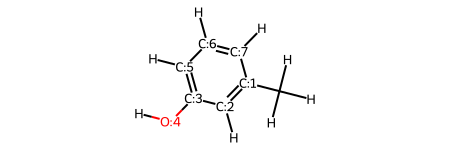

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,4,3,2,1,0,2,3,4,5,5,5,3,1,3,4,5


In [269]:
mol_ = AllChem.MolFromSmiles("Cc1cc(O)ccc1")
mol_ = AllChem.AddHs(mol_)
mol_

for atom in mol_.GetAtoms():
    if atom.GetAtomicNum() == 1:
        continue
    atom.SetAtomMapNum(atom.GetIdx())

display(mol_)

pd.DataFrame(GetDistanceMatrix(mol_).astype(int)[[4]])

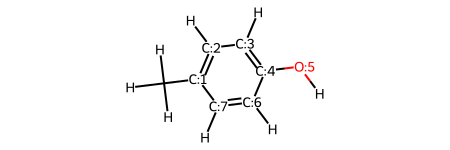

[5] [0, 1, 2, 3, 4, 6, 7]



,0,1,2,3,4,5,6,7
0,5.0,4.0,3.0,2.0,1.0,0.0,2.0,3.0


[4]


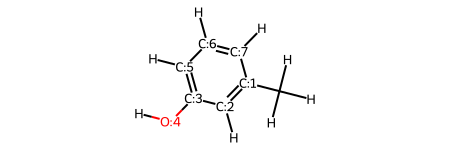

[4] [0, 1, 2, 3, 5, 6, 7]



,0,1,2,3,4,5,6,7
0,4.0,3.0,2.0,1.0,0.0,2.0,3.0,4.0


[3]


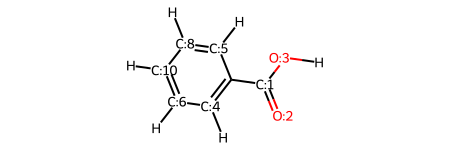

[2, 3] [0, 1, 4, 5, 6, 8, 10]



,0,1,2,3,4,5,6,7,8
0,2.0,1.0,0.0,1.0,2.0,3.0,2.0,1.0,2.0
1,3.0,2.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0


[1]


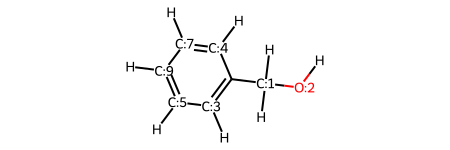

[2] [0, 1, 3, 4, 5, 7, 9]



,0,1,2,3,4,5,6,7
0,2.0,1.0,0.0,1.0,2.0,3.0,2.0,3.0


[1]


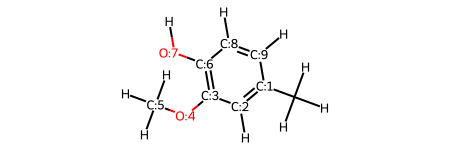

[4, 5, 7] [0, 1, 2, 3, 6, 8, 9]



,0,1,2,3,4,5,6,7,8,9
0,4.0,3.0,2.0,1.0,0.0,1.0,2.0,3.0,3.0,4.0
1,5.0,4.0,3.0,2.0,1.0,0.0,3.0,4.0,4.0,5.0
2,5.0,4.0,3.0,2.0,3.0,4.0,1.0,0.0,2.0,3.0


[3, 6]


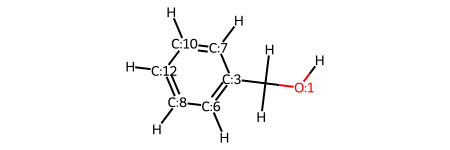

[1] [0, 3, 6, 7, 8, 10, 12]



,0,1,2,3,4,5,6,7
0,1.0,0.0,2.0,3.0,4.0,5.0,4.0,3.0


[0]


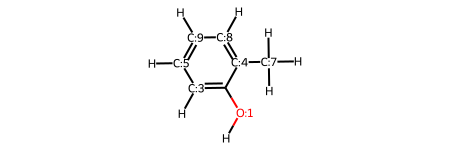

[1] [0, 3, 4, 5, 7, 8, 9]



,0,1,2,3,4,5,6,7
0,1.0,0.0,1.0,2.0,3.0,2.0,1.0,2.0


[0]


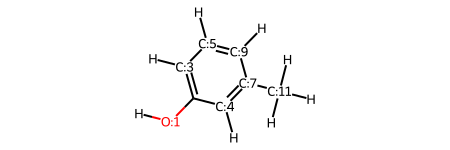

[1] [0, 3, 4, 5, 7, 9, 11]



,0,1,2,3,4,5,6,7
0,1.0,0.0,1.0,2.0,3.0,2.0,3.0,1.0


[0]


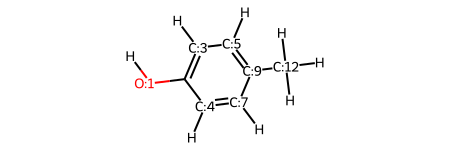

[1] [0, 3, 4, 5, 7, 9, 12]



,0,1,2,3,4,5,6,7
0,1.0,0.0,1.0,2.0,3.0,4.0,2.0,1.0


[0]


In [281]:
reactions = list(
    itertools.chain.from_iterable(
        [to_concrete_reactions(reaction, mol) for reaction in rules.Reaction]
    )
)

,Educt,Product,Reaction
0,,,aromatic_hydroxylation_(para_to_carbon)
1,,,aromatic_hydroxylation_(meta_to_carbon)
2,,,carboxylation_(benzylic_CH3)
3,,,benzylic_hydroxylation_(c-CH3)
4,,,aromatic_oxidation
5,,,aliphatic hydroxylation
6,,,aromatic hydroxylation
7,,,aromatic hydroxylation
8,,,aromatic hydroxylation

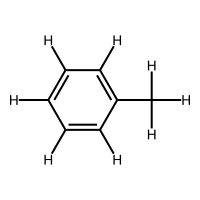
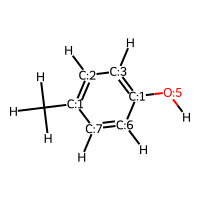
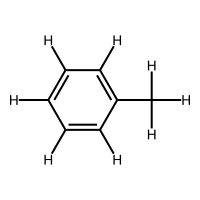
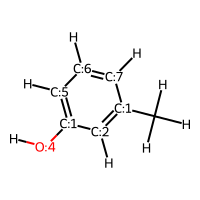
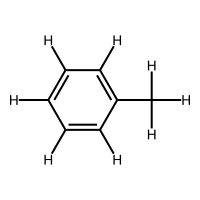
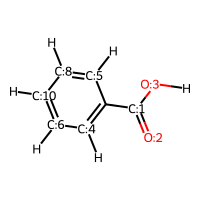
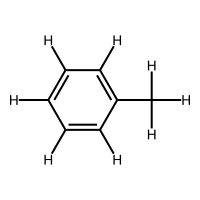
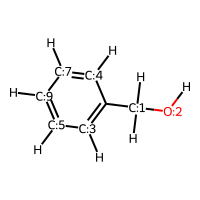
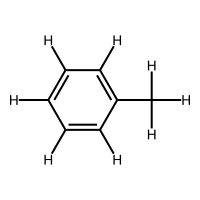
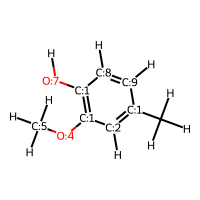
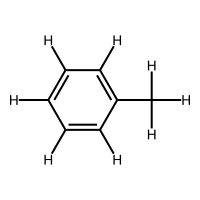
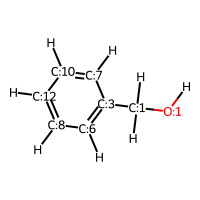
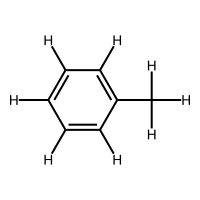
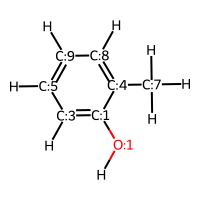
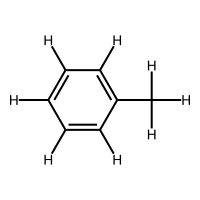
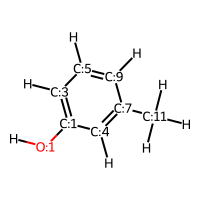
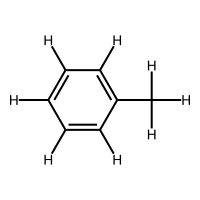
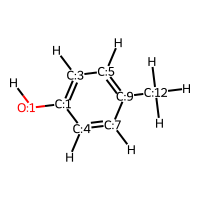

In [282]:
reactions_to_table(reactions)

In [165]:
reactions_to_table(reactions).pipe(
    lambda df: df.assign(
        Source=df.Reaction.map(lambda name: subset_mappings[name]),
        Descriptors=df.Educt.map(
            lambda mol: educt_som_descriptors(AllChem.MolToSmiles(mol))
        ),
    )
).pipe(
    lambda df: df.assign(
        Probabilities=df.apply(
            lambda row: models[row.Source].predict_proba(row.Descriptors)[:, -1], axis=1
        )
    )
).pipe(lambda df: df.assign(P_max=df.Probabilities.map(max)))[
    ["Educt", "Product", "Reaction", "Source", "Probabilities", "P_max"]
].sort_values(["P_max"], ascending=False)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Potential library design #1

In [ ]:
fame3cf.predict_proba(
    educt_som_descriptors(AllChem.MolToSmiles(rxn.GetReactantTemplate(0)))
)[:, -1]

In [ ]:
pd.Series(
    to_concrete_reactions(
        rules.loc["aromatic_hydroxylation_(para_to_nitrogen)", "Reaction"], mol
    )
).to_frame()

In [ ]:
def run_reactions(educt: AllChem.Mol):
    educt = AllChem.Mol(educt)
    for atom in educt.GetAtoms():
        atom.SetIntProp("_NotPotentialSOMIdx", atom.GetIdx())

    products = rules.Reaction.map(lambda rxn: rxn.RunReactants([educt])).pipe(
        lambda series: series[series != ()].map(np.concatenate)
    )
    products = products.map(
        lambda array: np.asarray(
            list({AllChem.MolToInchi(mol): mol for mol in array}.values())
        )
    )

    for name, rxn_products in products.items():
        for product in rxn_products:
            product.SetProp("Reaction", name)

    products = (
        np.concatenate(products.to_numpy())
        if not products.empty
        else np.array([], dtype=object)
    )

    return products

In [ ]:
def compute_som_probability(educt: AllChem.Mol, idxs_to_consider: list[int]):
    if len(idxs_to_consider) == 0:
        return None

    educt = AllChem.Mol(educt)

    for i, idx in enumerate(idxs_to_consider):
        educt.GetAtomWithIdx(idx).SetAtomMapNum(i + 1)

    cdpkit_marked_educt = Chem.parseSMILES(AllChem.MolToSmiles(educt))
    MoleculeProcessor.perceive_mol(cdpkit_marked_educt)

    cdpkit_potential_som_atoms = [
        atom
        for atom in cdpkit_marked_educt.getAtoms()
        if atom.getProperty(Chem.AtomProperty.ATOM_MAPPING_ID)
    ]

    fame3_descriptors = [
        famedg.generate_descriptors(atom, cdpkit_marked_educt)[1]
        for atom in cdpkit_potential_som_atoms
    ]

    return fame3cf.predict_proba(fame3_descriptors)[:, 1]

In [ ]:
def marked_educt(educt: AllChem.Mol, idxs: list[int]) -> AllChem.Mol:
    educt = AllChem.Mol(educt)

    # for i, idx in enumerate(idxs):
    #    educt.GetAtomWithIdx(idx).SetAtomMapNum(i + 1)

    educt.__sssAtoms = idxs

    return educt

In [ ]:
mol = AllChem.MolFromSmiles("c1ccccc1N")
mol = AllChem.AddHs(mol)
mol

In [ ]:
df = pd.DataFrame({"Educt": None, "Product": run_reactions(mol)})

In [ ]:
df["Reaction"] = df.Product.map(lambda product: product.GetProp("Reaction"))
df["Reaction class"] = df.Reaction.map(
    lambda name: rules.loc[name, "Name of rule subset"]
)

In [ ]:
df["IDX"] = df.Product.map(
    lambda product: [
        atom.GetIntProp("react_atom_idx")
        for atom in product.GetAtoms()
        if atom.HasProp("old_mapno") and atom.GetAtomicNum() != 1
    ]
)

df["Educt"] = df.IDX.map(lambda idx: marked_educt(mol, idx))

df["Probabilities"] = df.IDX.map(
    lambda idx_to_consider: compute_som_probability(
        mol,
        idx_to_consider,
    )
)

df["max(P)"] = df.Probabilities.map(max)

In [ ]:
df.drop(columns=["IDX", "Probabilities"]).sort_values(["max(P)"], ascending=False)

## Etc.

In [ ]:
[atom.GetPropsAsDict() for atom in df.Product[0].GetAtoms()]

In [ ]:
def atoms_equal(atom1, atom2):
    return (
        atom1.GetAtomicNum() == atom2.GetAtomicNum()
        # and atom1.GetFormalCharge() == atom2.GetFormalCharge()
        # and atom1.GetTotalNumHs() == atom2.GetTotalNumHs()
        # and atom1.GetHybridization() == atom2.GetHybridization()
        # and atom1.GetIsAromatic() == atom2.GetIsAromatic()
        # and atom1.GetChiralTag() == atom2.GetChiralTag()
    )

In [ ]:
rules.loc[10, "Reaction"]

In [ ]:
[atom.GetPropsAsDict() for atom in p.GetAtoms()]

In [ ]:
p = df.Product[5]

display(p)

potential_atoms = [
    atom.GetIntProp("react_atom_idx")
    for atom in p.GetAtoms()
    if atom.HasProp("old_mapno") and atom.GetIntProp("old_mapno")
]

mol.__sssAtoms = potential_atoms
display(mol)

potential_atoms

In [ ]:
p = df.Product[4]

display(p)

potential_atoms = {
    atom.GetIntProp("react_atom_idx"): atom
    for atom in p.GetAtoms()
    if atom.HasProp("react_atom_idx")
}

mol.__sssAtoms = [
    idx
    for idx, atom in potential_atoms.items()
    if atoms_equal(atom, mol.GetAtomWithIdx(idx))
]
mol

In [ ]:
mol.__sssAtoms = [0, 1, 2]
mol

In [ ]:
[atom.GetAtomicNum() for atom in mol.GetAtoms()]

In [ ]:
    # {
    #     atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() != 1
    # }.difference(
    #     {
    #         atom.GetIntProp("_NotPotentialSOMIdx")
    #         for atom in product.GetAtoms()
    #         if atom.HasProp("_NotPotentialSOMIdx")
    #     }
    # )

